In [24]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import import_ipynb
import importance_sampler_poise
import kl_divergence_calculator
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F  #for the activation function
from torchviz import make_dot
from numpy import prod, sqrt
import random
import umap
%matplotlib inline

In [2]:
## Creating synthetic datasets
NUM_SAMPLES = 5000

MEAN = torch.tensor([0.0, 0.0], dtype=torch.float32)
VARIANCE = torch.tensor([1.0, 1.0], dtype=torch.float32)

DEBUG = True

## Hyperparameters
BATCH_SIZE = 128
LATENT_DIM = [(1,), (1,)]
LEARNING_RATE = 1e-3
DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## IMPORTANCE SAMPLING PARAMETERS
NUM_IW_SAMPLES = 10 # TODO: WHAT IS THIS?

# OTHER PARAMETERS
DIM_EXP = 2 # DIMENSION TO CONVERT THE 1D DATA TO. 

In [3]:
if DEBUG:
    random.seed(30)
    torch.manual_seed(30)

In [23]:
# # HELPER FUNCTIONS
# def sample(mu: torch.tensor, var: torch.tensor, num_samples: int, add_noise: bool):
#     """
#     :param mu: Mean of the normal distribution from which we sample. Mean is one dimentional
#     :param var: torch.Tensor (features) (note: zero covariance)
#     :param num_samples: Number of samples in the dataset. 
#     :param add_noise: Add noise to the dataset.
#     :return: torch.Tensor (nb_samples, features)
#     """
#     assert mu.dim() == 0, "Mean should be single dimensional. It is {}".format(mu.dim())
#     assert var.dim() == 0, "Variance should be single dimensional. It is {}".format(var.dim())
#     assert num_samples > 0, "Number of samples is < 0. It is {}".format(num_samples)
#     output_list = []
#     for _ in range(num_samples):
#         output_list.append(torch.normal(mu, var.sqrt()))
#     # Stack on the first dimension
#     output_tensor = torch.stack(output_list, dim=0)
#     if add_noise:
#         noisy_tensor = output_tensor + torch.randn_like(output_tensor)
#         return noisy_tensor
#     else:
#         return output_tensor

## Generate Noisy Data

In [24]:
# input_data1_noisy = sample(MEAN[0], VARIANCE[0], NUM_SAMPLES, add_noise=True)  
# input_data2_noisy = sample(MEAN[1], VARIANCE[1], NUM_SAMPLES, add_noise=True)  

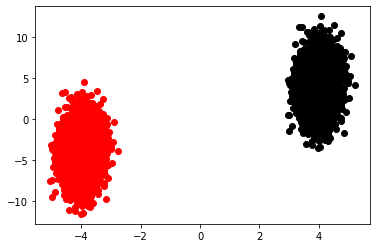

In [8]:
def sample_data(mu1,var1, NUM_SAMPLES):
    dim1 = mu1.size()[0]
    mn1  = torch.distributions.MultivariateNormal(mu1, torch.diag_embed(var1))
    return [mn1.sample([NUM_SAMPLES,])]
mu1  =4+torch.zeros(DIM_EXP)   
var1 =torch.tensor([0.1, 5.0])
data1 = sample_data(mu1,var1,NUM_SAMPLES) 
data1 = data1[0]
data2 = data1-8.0
x1_cord = data1[:,0]
y1_cord = data1[:,1]
x2_cord = data2[:,0]
y2_cord = data2[:,1]
plt.plot(x1_cord,y1_cord, 'o', color='black')
plt.plot(x2_cord,y2_cord, 'o', color='red')
plt.show()

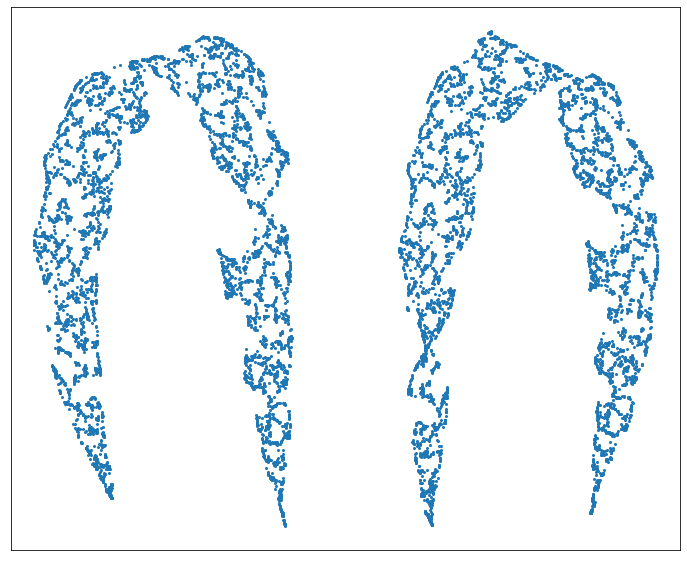

In [25]:
reducer = umap.UMAP()
data=torch.vstack((data1,data2))
embedding = reducer.fit_transform(data)
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], cmap="Spectral", s=4)
plt.setp(ax, xticks=[], yticks=[])
plt.gca().set_aspect('equal', 'datalim')
# plt.title("SVHN data embedded into two dimensions by UMAP", fontsize=18)
ax.set_facecolor('white')
plt.show()

## Visualize the Noisy Data (not working)

In [9]:
# ## for data visualization
# data_vis1 = input_data1_noisy.numpy()
# data_vis2 = input_data2_noisy.numpy()
# fig, ax = plt.subplots(2, 1)

# #Panel a
# n1, bins1, patches1 = ax[0].hist(data_vis1, 'auto', density=1)
# y1 = 1.0 / (np.sqrt( 2 * np.pi * VARIANCE[0])) * np.exp(-0.5 * (bins1 - MEAN[0].numpy()) ** 2 / VARIANCE[0])
# ax[0].plot(bins1,y1,'--')
# ax[0].set(xlabel='x',ylabel='p(x)')
# #Panel b
# n2,bins2,patches2=ax[1].hist(data_vis2,'auto',density=1)
# y2=1/(np.sqrt(2*np.pi*VARIANCE[1]))*np.exp(-0.5*(bins2-MEAN[1].numpy())**2/VARIANCE[1])
# ax[1].plot(bins2,y2,'--')
# ax[1].set(xlabel='x',ylabel='p(x)')
# plt.show()
# print("mu1",MEAN[0])
# print("var1",VARIANCE[0])
# print("mu2",MEAN[1])
# print("var2",VARIANCE[1])

In [10]:
# ## Transforming data to a higher dimension
# """
# inp_data= samplesx1
# fun_A   = 1xdim_exp
# data    = samplesxdim_exp   (data = inp_dataxfun_A)
# """

# #fun_A1   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
# #fun_A2   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
# fun_A1 = torch.tensor([1,1])
# fun_A2 = torch.tensor([1,-1])
# input_data1_noisy = input_data1_noisy.unsqueeze(1)
# input_data2_noisy = input_data2_noisy.unsqueeze(1)

# data1    = input_data1_noisy*fun_A1
# data2    = input_data2_noisy*fun_A2
# x1_cord = data1[:,0]
# y1_cord = data1[:,1]
# x2_cord = data2[:,0]
# y2_cord = data2[:,1]
# plt.plot(x1_cord,y1_cord, 'o', color='black')
# plt.plot(x2_cord,y2_cord, 'o', color='red')
# plt.show()

## Creating synthetic dataloader

In [11]:
train_loader_set1 = DataLoader(data1[:int(0.8 * NUM_SAMPLES),], batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader_set1 = DataLoader(
    data1[int(0.8*NUM_SAMPLES):,],
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)
train_loader_set2 = DataLoader(
    data2[:int(0.8*NUM_SAMPLES),],
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)
test_loader_set2 = DataLoader(
    data2[int(0.8*NUM_SAMPLES):,],
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

In [12]:
# Questions that John asked:
# Run only encoder: given x -> run encoder.

In [13]:
class Enc(nn.Module): # Linear
    def __init__(self, DIM_EXP):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(DIM_EXP, 8), 
                                 nn.LeakyReLU(inplace=True))
        self.nu1 = nn.Linear(8, 1)
        self.log_nu2 = nn.Linear(8, 1)
    def forward(self, x):
        x = self.enc(x)
        return self.nu1(x), self.log_nu2(x)
    
class Dec(nn.Module): 
    def __init__(self, DIM_EXP):
        super().__init__()
        self.dec = nn.Sequential(nn.Linear(1, 8), 
                                 nn.LeakyReLU(inplace=True),
                                 nn.Linear(8, DIM_EXP))
    def forward(self, z):
        return self.dec(z), torch.tensor(1).to(z.device)

In [14]:
enc1 = Enc(DIM_EXP).to(DEVICE)
dec1 = Dec(DIM_EXP).to(DEVICE)
enc2 = Enc(DIM_EXP).to(DEVICE)
dec2 = Dec(DIM_EXP).to(DEVICE)
encoders_list = [enc1, enc2]
decoders_list = [dec1, dec2] 
# vae = poisevae.POISEVAE([enc1, enc2], [dec1, dec2], likelihoods=[Normal, Normal], n_IW_sample=100,
#                         latent_dims=[2, 2], batch_size=batch_size, fix_t=True).to(device)

In [15]:
class VAE(nn.Module):
    def __init__(self, encoders_list, decoders_list, num_IW_samples, latent_dims, batch_size):
        super(VAE,self).__init__()
        self.encoders = nn.ModuleList(encoders_list)
        self.decoders = nn.ModuleList(decoders_list)
        self.latent_dims = latent_dims
        self.batch_size = batch_size
        self.num_IW_samples = num_IW_samples
        self.register_parameter(name='g11', param = nn.Parameter(torch.randn(*self.latent_dims[0],*self.latent_dims[1])))
        self.register_parameter(name='g22', param = nn.Parameter(torch.randn(*self.latent_dims[0],*self.latent_dims[1])))    
        self.IS_sampler = importance_sampler_poise.importance_sampler(*self.latent_dims[0], *self.latent_dims[1], self.batch_size)
        self.kl_div = kl_divergence_calculator.kl_divergence(*self.latent_dims[0], *self.latent_dims[1], self.batch_size)
    def get_G(self):
        g12   = torch.zeros(*self.latent_dims[0],*self.latent_dims[1]).to(DEVICE)
        g22   = -torch.exp(self.g22)        
        G1 = torch.cat((self.g11, g12), 0)
        G2 = torch.cat((g12, g22), 0)
        G  = torch.cat((G1, G2), 1)
        return G
    
    def encode(self, x):
        """
        Encode the samples from multiple sources
        Parameter
        ---------
        x: list of torch.Tensor
        Return
        ------
        z: list of torch.Tensor
        """
        nu1, nu2 = [], []

        for i, xi in enumerate(x):
            batch_size = xi.shape[0] 
            _nu1, _log_nu2 = self.encoders[i](xi)
            nu1.append(_nu1.view(batch_size, -1))
            nu2.append(-torch.exp(_log_nu2.view(batch_size, -1)))
        return nu1, nu2
    def decode(self, z):
        """
        Unsqueeze the samples from each latent space (if necessary), and decode
        Parameter
        ---------
        z: list of torch.Tensor
        Return
        ------
        x_rec: list of torch.Tensor
        """
        x_rec = []
#         a =[]
#         b=[]
#         i=0
        for decoder, zi, ld in zip(self.decoders, z, self.latent_dims):
            batch_shape = zi.shape[:-1]
#             ld =[1, ]
            zi = zi.view(prod(batch_shape), *ld) # Match the shape to the output
            x_ = list(decoder(zi))
            x_[0] = x_[0].view(*batch_shape, *x_[0].shape[1:])
            x_rec.append(x_)
#             if i==0:
#                 a=x_[0]
#                 i = i+1
#             if i==1:
#                 b=x_[0]
#             #x_rec.append(x_)
#         x_rec =[a,b]
        return x_rec
    def weighted_mse_loss(self,weights,reconstruction,data):
        #weights :[batch_size], reconstruction: [batch_size,2], data: [batch_size,2] , loss: #
        loss = torch.sum(weights * ((data - reconstruction) ** 2).T)
        return loss    
    def forward(self, x):
        data1 = x[0]
        data2 = x[1]
        nu1, nu2 = self.encode(x)
        mu1 = nu1[0]
        mu2 = nu1[1]
        var1  = nu2[0]
        var2  = nu2[1]
        G = self.get_G()
        z1_prior,z2_prior,z1_posterior,z2_posterior,IS_weights_prior,IS_weights_post = self.IS_sampler.calc(G, mu1, var1, mu2, var2,self.num_IW_samples)        
        ## decoding
        loss = 0
        weighted_reconstruction1 = torch.zeros_like(data1)              #[batch_size,2]
        weighted_reconstruction2 = torch.zeros_like(data2)
        for i in range(self.num_IW_samples):
            self.z1_IS_prior     = z1_prior[i]
            self.z2_IS_prior     = z2_prior[i]
            self.z1_IS_posterior = z1_posterior[i]
            self.z2_IS_posterior = z2_posterior[i]
            z = [self.z1_IS_posterior,self.z2_IS_posterior]
#             part_fun0,part_fun1,part_fun2 = self.kl_div.calc(G,self.z1_IS_posterior,self.z2_IS_posterior,self.z1_IS_prior,self.z2_IS_prior,mu1,var1,mu2,var2)
            x_rec = self.decode(z)
            reconstruction1 = x_rec[0][0]
            reconstruction2 = x_rec[1][0]
            ## loss
            MSE1 = self.weighted_mse_loss(IS_weights_post[i,:],reconstruction1, data1)
            MSE2 = self.weighted_mse_loss(IS_weights_post[i,:],reconstruction2, data2)
#             KLD  = torch.sum(IS_weights_post[i,:]*(torch.sum(part_fun0+part_fun1,dim=1)+part_fun2) )
            loss = loss + MSE1 + MSE2 
            weighted_reconstruction1 = weighted_reconstruction1 + (IS_weights_post[i,:]*reconstruction1.T).T
            weighted_reconstruction2 = weighted_reconstruction2 + (IS_weights_post[i,:]*reconstruction2.T).T
#         print(IS_weights_post[:,i].size())
#         print('hello',IS_weights_post[i,:].size())
        return weighted_reconstruction1,weighted_reconstruction2,mu1,var1,mu2,var2,loss
        

In [16]:
model = VAE(encoders_list, decoders_list, num_IW_samples =NUM_IW_SAMPLES, latent_dims = LATENT_DIM, batch_size = BATCH_SIZE).to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
for name, para in model.named_parameters():
    print(name)

g11
g22
encoders.0.enc.0.weight
encoders.0.enc.0.bias
encoders.0.nu1.weight
encoders.0.nu1.bias
encoders.0.log_nu2.weight
encoders.0.log_nu2.bias
encoders.1.enc.0.weight
encoders.1.enc.0.bias
encoders.1.nu1.weight
encoders.1.nu1.bias
encoders.1.log_nu2.weight
encoders.1.log_nu2.bias
decoders.0.dec.0.weight
decoders.0.dec.0.bias
decoders.0.dec.2.weight
decoders.0.dec.2.bias
decoders.1.dec.0.weight
decoders.1.dec.0.bias
decoders.1.dec.2.weight
decoders.1.dec.2.bias


In [17]:
def train(model, dataloader1, dataloader2):
    model.train()
    running_loss = 0
    for i,(data1,data2) in enumerate(zip(dataloader1,dataloader2)):
        data1                        = data1.to(DEVICE)
        data2                        = data2.to(DEVICE)   
        optimizer.zero_grad()
        data = [data1,data2]
        reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss       = model(data)
        running_loss                += loss.item()
        loss.backward() 
        optimizer.step()
    train_loss = running_loss/(len(dataloader1.dataset)+len(dataloader2.dataset))
    return train_loss
def test(model,dataloader1,dataloader2):
    mean1_pred = []
    var1_pred  = []
    mean2_pred = []
    var2_pred  = []
    data1_val  = [] 
    data2_val  = [] 
    reconstruction1_pred=[]
    reconstruction2_pred=[]
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i,(data1,data2) in enumerate(zip(dataloader1,dataloader2)):
            data1                        = data1.to(DEVICE)
            data2                        = data2.to(DEVICE)    
            data = [data1,data2]
            reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss = model(data)  
            running_loss              += loss.item()
            mean1_pred                += [torch.mean(mu1)]
            var1_pred                 += [torch.mean(var1)]
            mean2_pred                += [torch.mean(mu2)]
            var2_pred                 += [torch.mean(var2)]
            reconstruction1_pred.append(reconstruction1)
            reconstruction2_pred.append(reconstruction2)
            data1_val.append(data1)
            data2_val.append(data2)

    test_loss   = running_loss/(len(dataloader1.dataset)+len(dataloader2.dataset))
    reconstruction1_pred = torch.vstack(reconstruction1_pred)
    reconstruction2_pred = torch.vstack(reconstruction2_pred)
    data1_val   = torch.vstack(data1_val)
    data2_val   = torch.vstack(data2_val)

    mean1_pred  = torch.stack(mean1_pred,dim=0)
    var1_pred   = torch.stack(var1_pred,dim=0)
    mean1_pred  = torch.mean(mean1_pred)
    var1_pred   = torch.mean(var1_pred)
    mean2_pred  = torch.stack(mean2_pred,dim=0)
    var2_pred   = torch.stack(var2_pred,dim=0)
    mean2_pred  = torch.mean(mean2_pred)
    var2_pred   = torch.mean(var2_pred)
    return data1_val,data2_val,reconstruction1_pred,reconstruction2_pred,test_loss,mean1_pred,var1_pred,mean2_pred,var2_pred

In [18]:
epochs     = 50
train_loss = []
test_loss = []
from tqdm import tqdm
for epoch in tqdm(range(epochs)):
#     print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model,train_loader_set1,train_loader_set2)
    data1_val,data2_val,reconstruction1_pred,reconstruction2_pred,test_epoch_loss,mean1_pred,var1_pred,mean2_pred,var2_pred = test(model,test_loader_set1,test_loader_set2)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
#     for name, para in model.named_parameters():
#         print(para)
print(f"Train Loss    : {train_epoch_loss:.4f}")
print(f"Test Loss     :  {test_epoch_loss:.4f}")
print(f"Mean Pred set1:  {mean1_pred:.4f}")
print(f"Var  Pred set1:  {var1_pred:.4f}")
print(f"Mean Pred set2:  {mean2_pred:.4f}")
print(f"Var  Pred set2:  {var2_pred:.4f}")

100%|██████████| 50/50 [00:26<00:00,  1.90it/s]

Train Loss    : 2.0451
Test Loss     :  1.7086
Mean Pred set1:  0.4147
Var  Pred set1:  -3.4863
Mean Pred set2:  1.8264
Var  Pred set2:  -3.1560


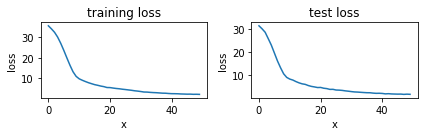

In [19]:
flg,(ax1,ax2)=plt.subplots(1,2,figsize=(6, 2))
ax1.plot(train_loss)
ax1.set(xlabel='x',ylabel='loss',title='training loss')
ax2.plot(test_loss)
ax2.set(xlabel='x',ylabel='loss',title='test loss')
flg.tight_layout()
plt.show()

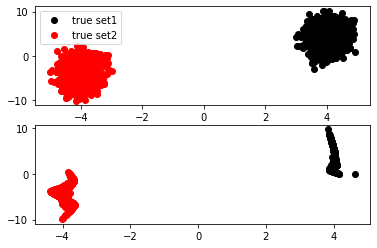

In [21]:
reconstruction1_pred_final =np.reshape(reconstruction1_pred.cpu().detach().numpy(),(896,2))
reconstruction2_pred_final =np.reshape(reconstruction2_pred.cpu().detach().numpy(),(896,2))
# reconstruction1_pred =np.reshape(reconstruction1_pred,(896,2))
# reconstruction2_pred =np.reshape(reconstruction2_pred,(896,2))
reconstruction1_x_cord = reconstruction1_pred_final[:,0]
reconstruction1_y_cord = reconstruction1_pred_final[:,1]
reconstruction2_x_cord = reconstruction2_pred_final[:,0]
reconstruction2_y_cord = reconstruction2_pred_final[:,1]
data1_x_cord = data1_val[:,0].cpu().detach().numpy()
data1_y_cord = data1_val[:,1].cpu().detach().numpy()
data2_x_cord = data2_val[:,0].cpu().detach().numpy()
data2_y_cord = data2_val[:,1].cpu().detach().numpy()

fig, ax = plt.subplots(2)

ax[0].plot(data1_x_cord,data1_y_cord, 'o', color='black',label='true set1')
ax[0].plot(data2_x_cord,data2_y_cord, 'o', color='red',label='true set2')
ax[0].legend()
for i in range(896):
    ax[1].plot(reconstruction1_x_cord[i],reconstruction1_y_cord[i], 'o', color='black' ,label='recon set1')
    ax[1].plot(reconstruction2_x_cord[i],reconstruction2_y_cord[i], 'o', color='red',label='recon set2')
#ax[1].legend()
plt.show()
# ax[1].plot(reconstruction1_x_cord,reconstruction1_y_cord, 'o', color='black',label='recon set1')
# ax[1].plot(reconstruction2_x_cord,reconstruction2_y_cord, 'o', color='red',label='recon set2')
# ax[1].legend()
# plt.show()

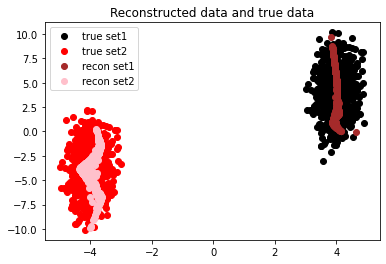

In [22]:
plt.plot(data1_x_cord,data1_y_cord, 'o', color='black',label='true set1')
plt.plot(data2_x_cord,data2_y_cord, 'o', color='red',label='true set2')
plt.plot(reconstruction1_x_cord,reconstruction1_y_cord, 'o', color='brown',label='recon set1')
plt.plot(reconstruction2_x_cord,reconstruction2_y_cord, 'o', color='pink',label='recon set2')
plt.title('Reconstructed data and true data')
plt.legend()
plt.show()

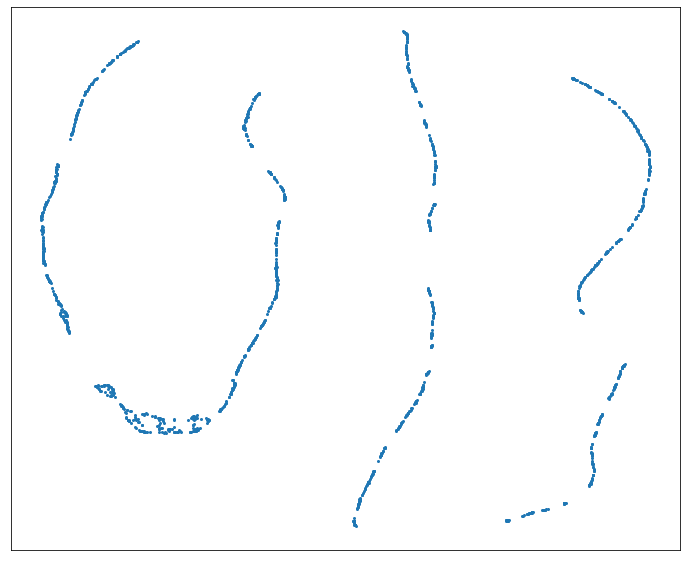

In [26]:
reducer = umap.UMAP()
data=torch.vstack((reconstruction1_pred.cpu(),reconstruction2_pred.cpu()))
embedding = reducer.fit_transform(data)
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], cmap="Spectral", s=4)
plt.setp(ax, xticks=[], yticks=[])
#plt.title("SVHN data embedded into two dimensions by UMAP", fontsize=18)
ax.set_facecolor('white')
plt.show()